<a href="https://colab.research.google.com/github/myconcordia/A2I2/blob/main/Anomaly_Detection_with_PyOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Anomaly Detection with PyOD**

Check Python Version in Jupyter Notebook

In [2]:
from platform import python_version
python_version()

'3.7.12'

**Installing PyOD**

PyOD is a comprehensive and scalable Python toolkit for detecting outlying objects in multivariate data. 

In [3]:
!pip3 install pyod

     |████████████████████████████████| 113 kB 4.1 MB/s 
  Created wheel for pyod: filename=pyod-0.9.5-py3-none-any.whl size=132699 sha256=1de3d65cf496aa62a17e3724ec01181bf82dc487be28a27739647f6b98d046f2
  Stored in directory: /root/.cache/pip/wheels/3d/bb/b7/62b60fb451b33b0df1ab8006697fba7a6a49709a629055cf77
Successfully built pyod


**Import Libraries**

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import percentile
import matplotlib
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
plt.rcParams['figure.figsize'] = (12,8)

from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score
from sklearn.metrics import classification_report, auc, roc_curve, f1_score 

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

**Dataset**

This is simple data set of US superstore from 2014-2018.

In [5]:
#read cvs file into dataframe
df = pd.read_csv('https://raw.githubusercontent.com/myconcordia/A2I2/main/Superstore.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Row ID,9994.0,4997.500000,2885.163629,1.000,2499.25000,4997.5000,7495.750,9994.000
Postal Code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
Sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480
Quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
Discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
Profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


Notice that the data is not standardizd.

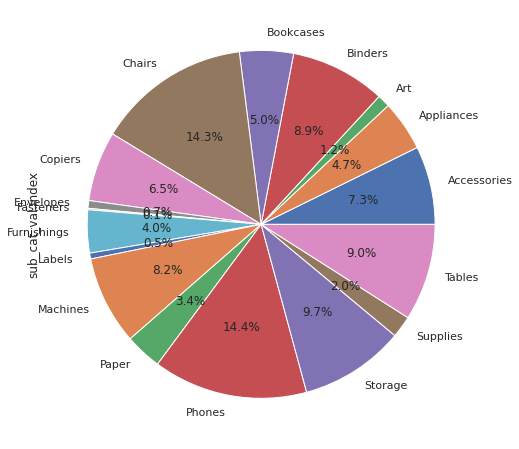

In [9]:
# Pie Chart for Sub-Category

plt.figure.figsize = (20,20)
sub_cat_val = df.groupby('Sub-Category')['Sales'].sum()

sub_cat_val.plot(kind = 'pie', autopct='%1.1f%%', label = 'sub_cat_val.index' )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


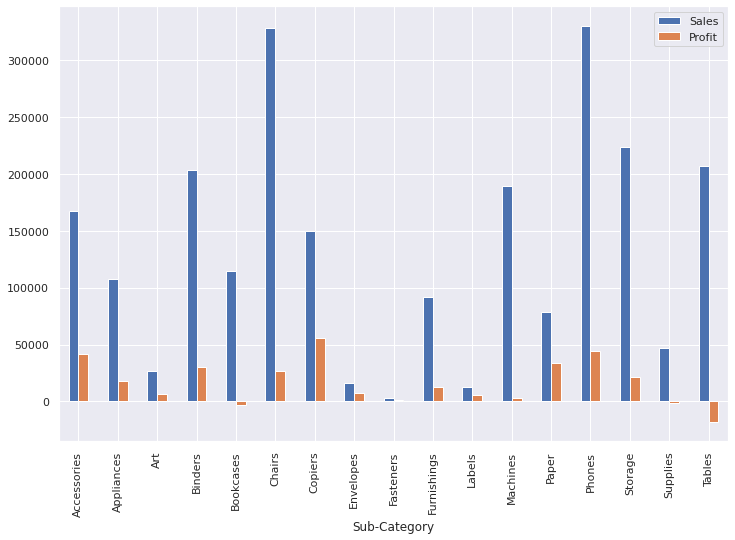

In [10]:
# group by Sub-Category
df.groupby('Sub-Category')['Sales', 'Profit'].sum().plot.bar();

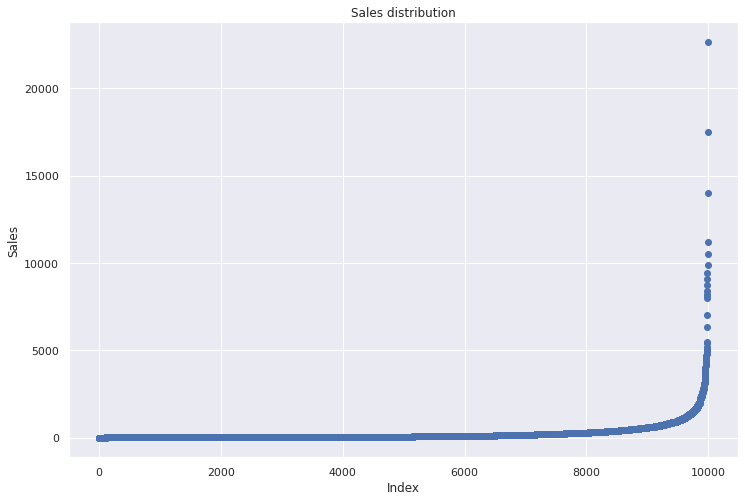

In [11]:
# lets check Sales
sales_sorted = np.sort(df['Sales'].values)

plt.scatter(range(df.shape[0]), sales_sorted)
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Sales distribution');

**Observations:**

(1) Any Sales more than 10000 should be considered as outlier.

(2) Phones generate the maximum revenew but copier bring more profit.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


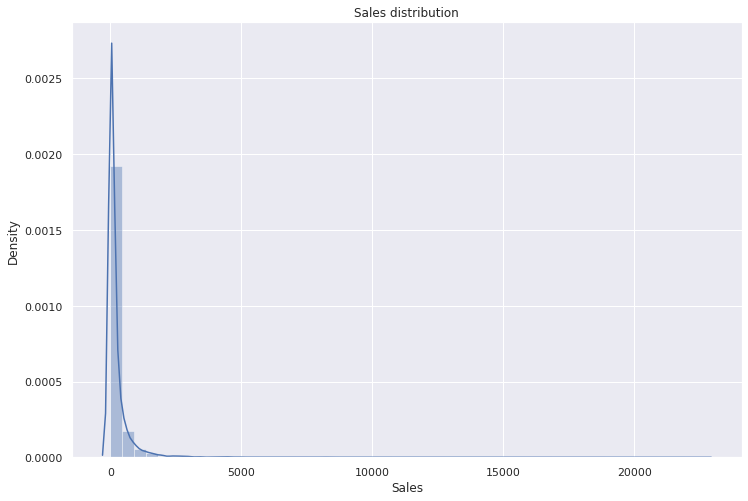

In [12]:
#histogram
sns.distplot(df['Sales'])
plt.title('Sales distribution');

In [13]:
# check skewness and Kurtosis
print('Skewness is :',df['Sales'].skew())
print('Kurtosis is :',df['Sales'].kurt())

Skewness is : 12.97275234181623
Kurtosis is : 305.311753246823


Skewness assesses the extent to which a variable’s distribution is symmetrical. If the distribution of responses for a variable stretches toward the right or left tail of the distribution, then the distribution is referred to as skewed. Kurtosis is a measure of whether the distribution is too peaked (a very narrow distribution with most of the responses in the center).

#**Univariate Anomaly Detection**

**Isolation Forest**

(1) Similiar to Random Forest as it is build on an ensemble of trees.

(2) Good for large dataset

(3) Outlier will have its own leaf. Isolation forest detects that leaf.

In [14]:
from sklearn.ensemble import IsolationForest

# IsloationForest on sales
clf = IsolationForest(n_estimators = 100)
clf.fit(df['Sales'].values.reshape(-1,1))

IsolationForest()

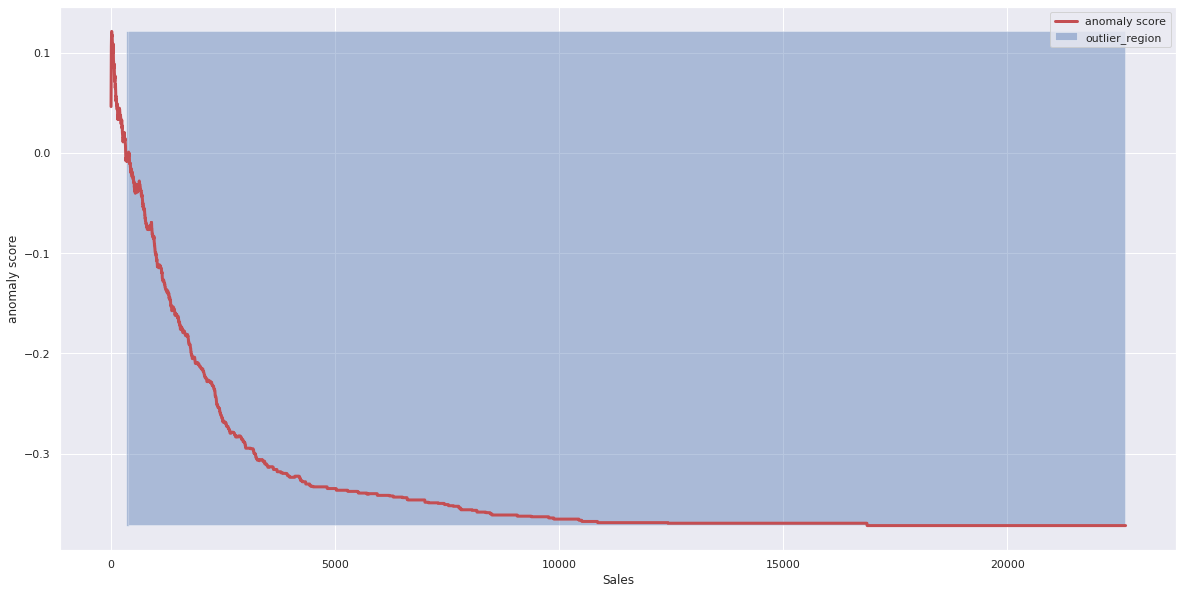

In [15]:
# fit the model
# clf = IsolationForest(max_samples=100, random_state=rng)
# clf.fit(X_train)
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
anomaly_score = clf.decision_function(xx)
outlier = clf.predict(xx)
plt.figure(figsize=(20,10))
plt.plot(xx, anomaly_score, color= 'r', linewidth =3, label='anomaly score')
# plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
#                  where=outlier==-1, color='r', 
#                  alpha=.4, label='outlier region')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                alpha = 0.4, where = outlier == -1,
                label = 'outlier_region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show()

#**Multivariate Anomaly Detection**

In [16]:
# keeping only Sales and Profit
cols = ['Sales', 'Profit']
df[cols].head()

,Sales,Profit
0,261.9600,41.9136
1,731.9400,219.5820
2,14.6200,6.8714
3,957.5775,-383.0310
4,22.3680,2.5164


In [17]:
# Scale features
minmax = MinMaxScaler(feature_range = (0, 1))
df[['Sales', 'Profit']] = minmax.fit_transform(df[['Sales', 'Profit']])
df[['Sales', 'Profit']].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Row ID,9994.0,4997.500000,2885.163629,1.0,2499.250000,4997.500000,7495.750000,9994.0
Postal Code,9994.0,55190.379428,32063.693350,1040.0,23223.000000,56430.500000,90008.000000,99301.0
Sales,9994.0,0.010134,0.027531,0.0,0.000744,0.002387,0.009254,1.0
Quantity,9994.0,3.789574,2.225110,1.0,2.000000,3.000000,5.000000,14.0
Discount,9994.0,0.156203,0.206452,0.0,0.000000,0.200000,0.200000,0.8
Profit,9994.0,0.441910,0.015617,0.0,0.440115,0.440578,0.441957,1.0


Notice that the data (Sales and Profit) are now standardized.

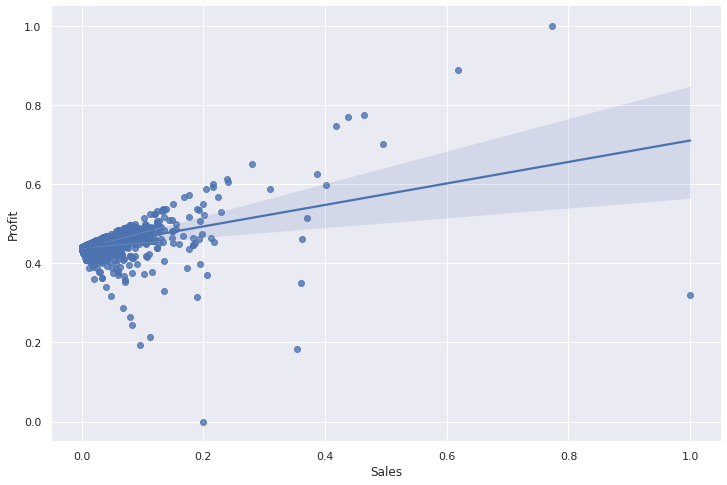

In [19]:
# Multi-variate Analysis using Sales and Profit
sns.regplot(x = 'Sales', y = 'Profit', data = df)
sns.despine();

In [20]:
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)
X

array([[0.01155206, 0.44279413],
       [0.0323127 , 0.45463873],
       [0.0006262 , 0.44045798],
       ...,
       [0.01140258, 0.44129277],
       [0.00128792, 0.44088789],
       [0.0107216 , 0.4448631 ]])

**Isolation forest**

Isolate observations through random feature selection

Random select a split value between max and min values of selected feature

OUTLIERS:  499 INLIERS:  9495


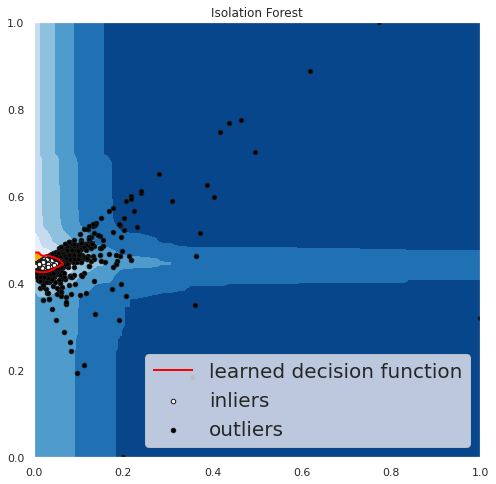

In [22]:
outliers_fraction = 0.05
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1

y = clf.predict(X)  #Labels
n_inliers = len(y) - np.count_nonzero(y)
n_outliers = np.count_nonzero(y == 1)
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)

threshold = percentile(scores_pred, 100 * outliers_fraction)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 25)                75        
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                2

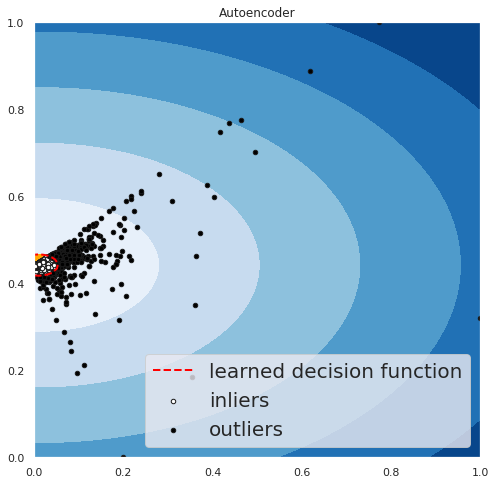

In [23]:
from pyod.models.auto_encoder import AutoEncoder

outliers_fraction = 0.05
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = AutoEncoder(hidden_neurons =[25,10,2,10,25],hidden_activation='relu',output_activation='sigmoid',
                  loss='mean_squared_error',optimizer='adam',dropout_rate=0.2,
                  epochs=100,batch_size=32,l2_regularizer=0.1,validation_size=0.1,contamination=outliers_fraction)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1

y = clf.predict(X)  #Labels
n_inliers = len(y) - np.count_nonzero(y)
n_outliers = np.count_nonzero(y == 1)
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)

threshold = percentile(scores_pred, 100 * outliers_fraction)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Autoencoder')
plt.show();

**Labels**

In [24]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
#Determine the number of anomalous and normal instances in the dataset.
anomalous = y[y == 1]
normal = y[y == 0]
outlier_fraction = len(anomalous)/float(len(normal))

#Now let us print the outlier fraction and number of anomalous and normal instances
print(outlier_fraction)
print("Anomalous Instances : {}".format(len(anomalous)))
print("Normal Instances : {}".format(len(normal)))

0.052664840952180325
Anomalous Instances : 500
Normal Instances : 9494


Show the counts of observations in each categorical bin using bars.

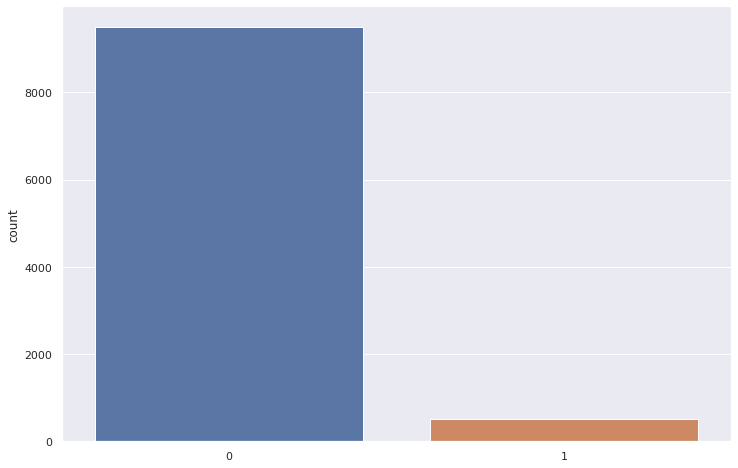

In [26]:
sns.countplot(x = y, data = pd.DataFrame(y))

In [27]:
# add outlier_scores column: outlier_scores do not change when outliers_fraction changes
df['outlier_scores'] = scores_pred
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,outlier,outlier_scores
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,0.011552,2,0.00,0.442794,0,-0.065927
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",0.032313,3,0.00,0.454639,0,-1.135418
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,0.000626,2,0.00,0.440458,0,-0.366785
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,0.042280,5,0.45,0.414464,1,-2.112377
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,0.000968,2,0.20,0.440168,0,-0.360561


In [28]:
# split into independent variables and target variable 
X = df[['Sales','Profit']]
y = df['outlier']

**Check Anomalies**

In [29]:
df[df['outlier'] == 1].head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,outlier,outlier_scores
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,0.042280,5,0.45,0.414464,1,-2.112377
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,0.075348,9,0.20,0.445687,1,-2.373140
24,25,CA-2015-106320,2015-09-25,2015-09-30,Standard Class,EB-13870,Emily Burns,Consumer,United States,Orem,Utah,84057,West,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,0.046125,3,0.00,0.456018,1,-1.578722
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,Pennsylvania,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",0.136186,7,0.50,0.328996,1,-8.560824
54,55,CA-2016-105816,2016-12-11,2016-12-17,Standard Class,JM-15265,Janet Molinari,Corporate,United States,New York City,New York,10024,East,TEC-PH-10002447,Technology,Phones,AT&T CL83451 4-Handset Telephone,0.045477,5,0.00,0.459912,1,-1.714828


#**Data Splitting with Labels**

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)

print('Training Data for Modeling: ' + str(X_train.shape))
print('Test Data For Predictions: ' + str(X_test.shape))

Training Data for Modeling: (6995, 2)
Test Data For Predictions: (2999, 2)


In [ ]:
#plt.scatter(X_train.loc[:,"Sales"], X_train.loc[:,"Profit"], alpha=0.8) 

In [32]:
from pyod.models.auto_encoder import AutoEncoder
clf_name = 'Autoencoder'
#[25, 10, 2, 10, 25]. There are three hidden layers with 10, 2, 10 neurons respectively.
clf = AutoEncoder(hidden_neurons =[25,10,2,10,25],hidden_activation='relu',output_activation='sigmoid',
                  loss='mean_squared_error',optimizer='adam',dropout_rate=0.2,
                  epochs=100,batch_size=32,l2_regularizer=0.1,validation_size=0.1,contamination=outliers_fraction)
clf.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 2)                 6         
                                                                 
 dropout_7 (Dropout)         (None, 2)                 0         
                                                                 
 dense_9 (Dense)             (None, 2)                 6         
                                                                 
 dropout_8 (Dropout)         (None, 2)                 0         
                                                                 
 dense_10 (Dense)            (None, 25)                75        
                                                                 
 dropout_9 (Dropout)         (None, 25)                0         
                                                                 
 dense_11 (Dense)            (None, 10)               

AutoEncoder(batch_size=32, contamination=0.05, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 10, 2, 10, 25],
      l2_regularizer=0.1, loss='mean_squared_error', optimizer='adam',
      output_activation='sigmoid', preprocessing=True, random_state=None,
      validation_size=0.1, verbose=1)

**Visualize the model**

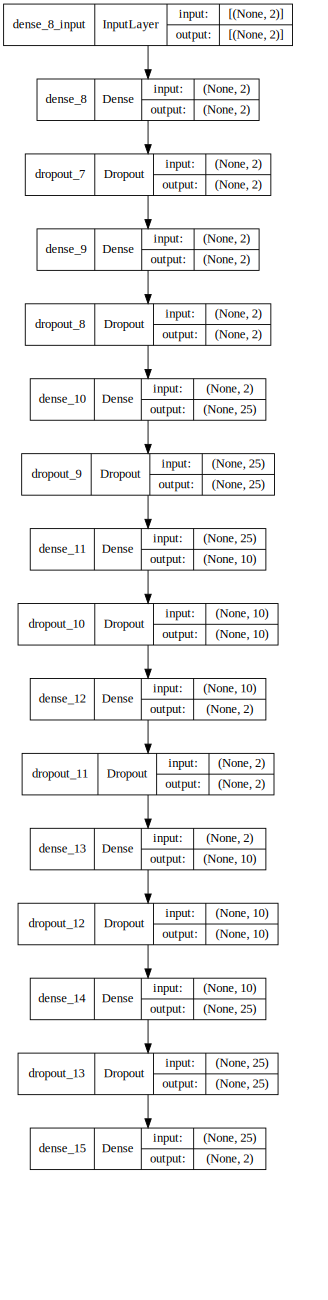

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(clf.model_, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

**Plot the Loss Functions**

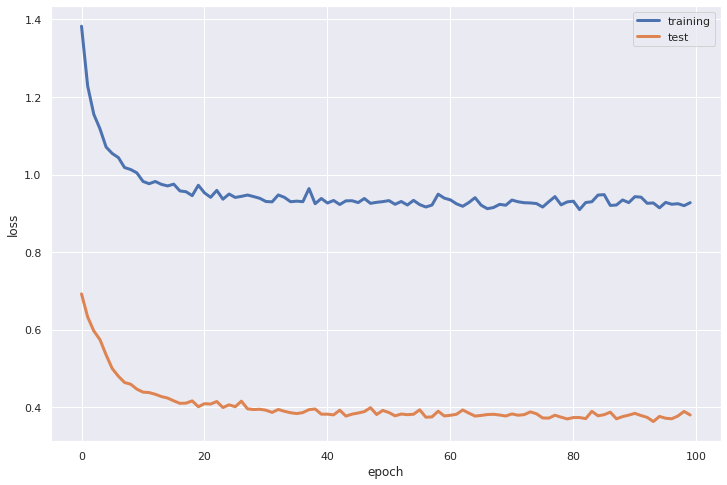

In [34]:
history = clf.history_
plt.plot(history['loss'], linewidth = 3)
plt.plot(history['val_loss'], linewidth = 3)
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'test'], loc='upper right')
plt.show()

In [35]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # anomaly scores

In [36]:
y_train_pred

array([0, 1, 0, ..., 0, 0, 0])

In [37]:
y_train_scores

array([0.26691373, 1.32399331, 0.38084982, ..., 0.5340668 , 0.22671666,
       0.36476628])

**Plot Anomaly Scores**

In [38]:
# calculate threshold
clf.threshold_

1.133935388214003

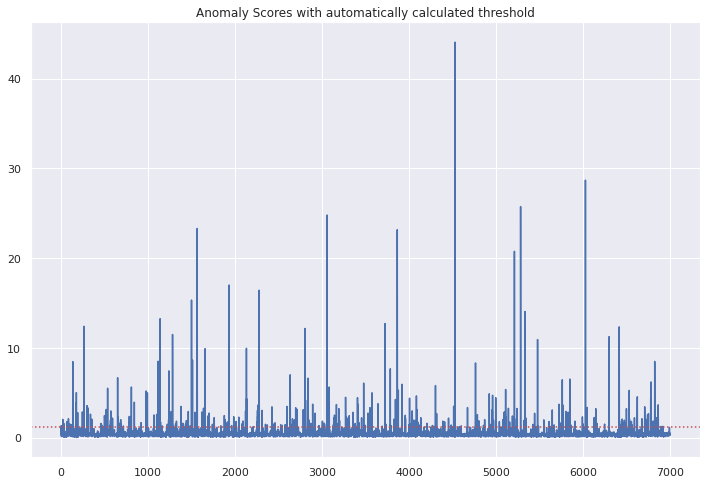

In [39]:
plt.plot(y_train_scores);
plt.axhline(y=clf.threshold_, c='r', ls='dotted', label='threshoold');
plt.title('Anomaly Scores with automatically calculated threshold');

In [40]:
!pip3 install scikit-plot

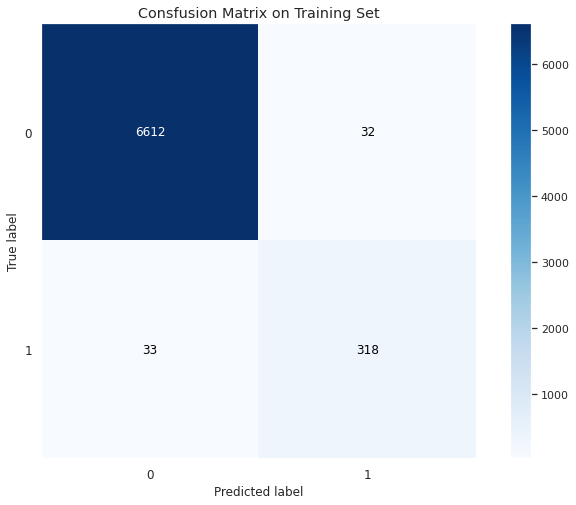

In [41]:
import scikitplot as skplt

# plot the comfusion matrix in the training set 
skplt.metrics.plot_confusion_matrix(y_train,y_train_pred, normalize=False, title="Consfusion Matrix on Training Set")
plt.show()

In [42]:
import warnings
warnings.filterwarnings('ignore')

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
Autoencoder ROC:0.9987, precision @ rank n:0.9088

On Test Data:
Autoencoder ROC:0.9985, precision @ rank n:0.8926


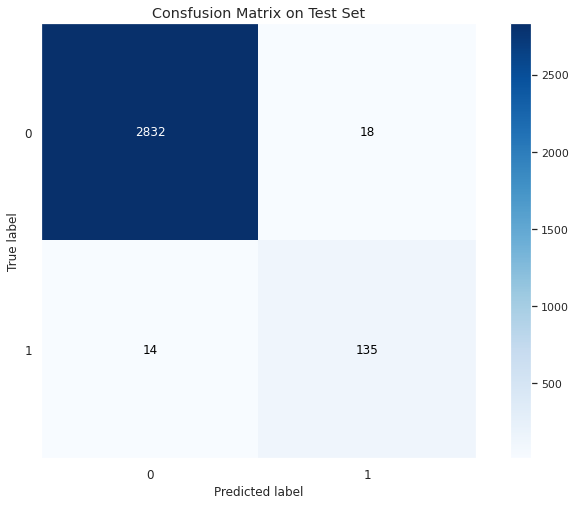

In [44]:
import scikitplot as skplt

# plot the comfusion matrix in the test set 
skplt.metrics.plot_confusion_matrix(y_test,y_test_pred, normalize=False, title="Consfusion Matrix on Test Set")
plt.show()

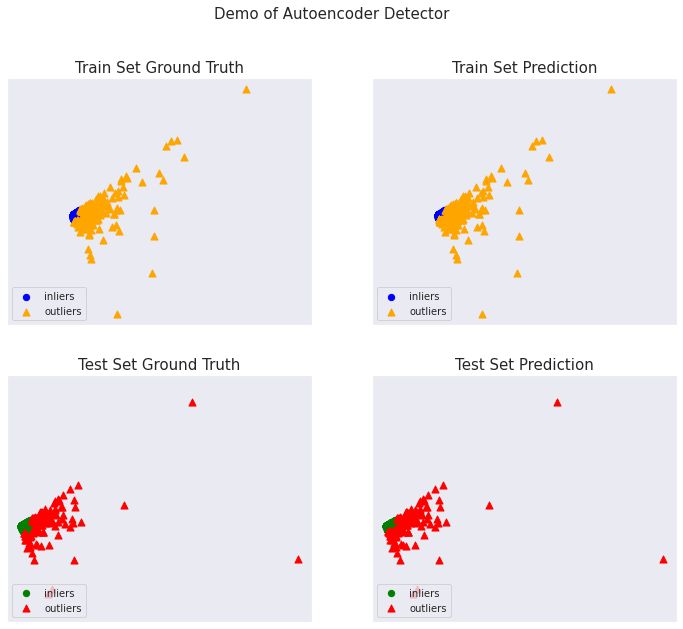

In [45]:
from pyod.utils.example import visualize

#Visualize the outliers
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

#**Autoencoders with Keras**

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers

In [ ]:
# Autoencocer

no_epochs = 50
batch_size = 32
input_dim = X_train.shape[1]

encoding_dim = 10
hidden_dim = encoding_dim / 2 # keeping hidden half
learning_rate = 1e-7


#model starts here
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation = 'tanh', activity_regularizer = regularizers.l1(learning_rate)) (input_layer)
encoder = Dense(hidden_dim, activation = 'relu')(encoder)
decoder = Dense(hidden_dim, activation = 'tanh')(encoder)
decoder = Dense(input_dim, activation = 'relu')(decoder)

autoencoder = Model(inputs = input_layer, outputs = decoder)

In [ ]:
# compile and run the model
autoencoder.compile(metrics = ['accuracy'],
                   loss = 'mean_squared_error',
                   optimizer = 'adam')

hist = autoencoder.fit(X_train, X_train,
                      epochs =no_epochs,
                      batch_size = batch_size,
                      shuffle = True,
                      validation_data = (X_test, X_test))

In [ ]:
print('The accuracy is {0:.2f}% '.format(100*hist.history['accuracy'][-1]))

The accuracy is 100.00% 


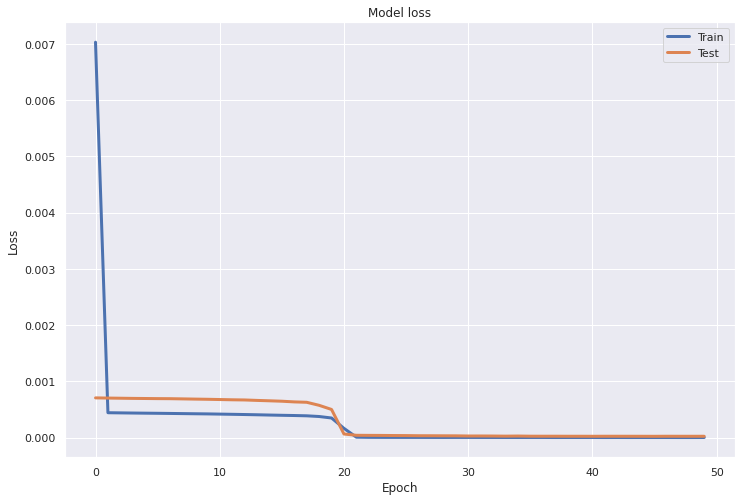

In [ ]:
# Plotting model loss
plt.plot(hist.history['loss'], linewidth =3, label = 'Train')
plt.plot(hist.history['val_loss'], linewidth =3, label = 'Test')

plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#making predictions

X_test_pred = autoencoder.predict(X_test)
mse_pred = np.mean(np.power(X_test - X_test_pred, 2), axis =1)

df_error = pd.DataFrame({'Error': mse_pred, 'True_class': y_test})

df_error.describe()

,Error,True_class
count,1.999000e+03,1999.000000
mean,2.437855e-05,0.013007
std,1.031828e-03,0.113330
min,1.103772e-08,0.000000
25%,6.072482e-08,0.000000
50%,9.606304e-08,0.000000
75%,1.111760e-07,0.000000
max,4.611521e-02,1.000000


In [ ]:
df_error.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 8865 to 8128
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Error       1999 non-null   float64
 1   True_class  1999 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 46.9 KB


In [ ]:
df_error.head()

,Error,True_class
8865,9.458260e-08,0
4049,2.395478e-08,0
11,8.668558e-08,0
7505,1.346877e-07,0
2102,7.120266e-08,0


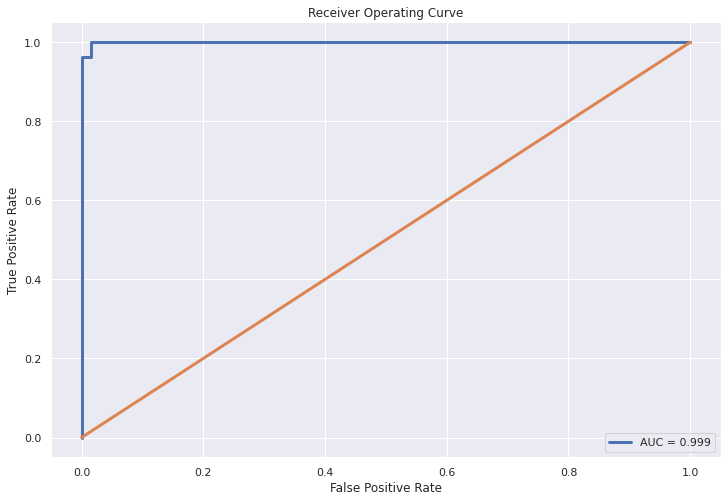

In [ ]:
# plotting roc curve

false_pos_rate , true_pos_rate, thresholds = roc_curve(df_error['True_class'], df_error['Error'])
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.plot(false_pos_rate, true_pos_rate, linewidth = 3, label = 'AUC = %0.3f'% roc_auc)
plt.plot([0,1], [0,1],linewidth = 3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')

plt.legend();